In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

def pol2cart(r, tet, phi):
    x = r*np.sin(tet)*np.cos(phi)
    y = r*np.sin(tet)*np.sin(phi)
    z = r*np.cos(tet)
    return x,y,z

def cart2pol(vec):
    x = vec[0]
    y = vec[1]
    z = vec[2]
    r = np.linalg.norm(vec)
    tet = np.arccos(z/r)
    phi = np.arctan(y/x)
    return r, tet, phi

def r_ort(tet, phi):
    x = np.sin(tet)*np.cos(phi)
    y = np.sin(tet)*np.sin(phi)
    z = np.cos(tet)
    return np.array([x, y, z])

def tet_ort(tet, phi):
    x = np.cos(tet)*np.cos(phi)
    y = np.cos(tet)*np.sin(phi)
    z = -np.sin(tet)
    return np.array([x, y, z])

def phi_ort(tet, phi):
    x = -np.sin(phi)
    y = np.cos(phi)
    z = 0
    return np.array([x, y, z])


In [2]:
import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector

class Material:
    def __init__(self, Ms, gamma=5e8, alpha=0.018, Hkeff= lambda t: 6.1e3, t=5e-9):
        self.Ms = Ms
        self.gamma = gamma
        self.alpha = alpha
        self.Hkeff = Hkeff
        self.t = t

        
class LayeredFilm:
    def __init__(self, layer1, layer2, J):
        self.l1 = layer1
        self.l2 = layer2
        self.J = J


class DemagnetizationEnergy:
    def __init__(self):
        S = CoordSys3D('S')
        
        Mz = symbols("Mz")
        self.E_eq = 2*sym.pi*(Mz**2)
        
    def Heff(self, M):
        return np.array([0., 0., -4.*np.pi*M[2]])

class StoenerWolfarthEnergy:
    def __init__(self):
        S = CoordSys3D('S')
        
        Ku = symbols("Ku")
        Mx, My, Mz = symbols('Mx My Mz')
        M = Mx*S.i + My*S.j + Mz*S.k
        
        sin_tet_sqr = (Mx**2 + My**2)/(Mx**2 + My**2 + Mz**2)
        
        self.E_eq = Ku*sin_tet_sqr
        
        Hx = -sym.diff(self.E_eq, Mx)
        Hy = -sym.diff(self.E_eq, My)
        Hz = -sym.diff(self.E_eq, Mz)
        
        lambda_var_set = (Ku, Mx, My, Mz)
        self.Heff_x = lambdify(lambda_var_set, Hx, 'numpy')
        self.Heff_y = lambdify(lambda_var_set, Hy, 'numpy')
        self.Heff_z = lambdify(lambda_var_set, Hz, 'numpy')
    
    def Heff(self, M, Ku):
        return np.array([
            self.Heff_x(Ku, M[0], M[1], M[2]),
            self.Heff_y(Ku, M[0], M[1], M[2]),
            self.Heff_z(Ku, M[0], M[1], M[2])
        ])

class IEC_Energy:
    def __init__(self):
        S = CoordSys3D('S')
        
        J, t = symbols("J t")
        
        Mx1, My1, Mz1 = symbols('Mx1 My1 Mz1')
        M1 = Mx1*S.i + My1*S.j + Mz1*S.k
        
        Mx2, My2, Mz2 = symbols('Mx2 My2 Mz2')
        M2 = Mx2*S.i + My2*S.j + Mz2*S.k
        
        self.E_eq = (J/t)*M1.dot(M2)/(M1.magnitude()*M2.magnitude())
        
        Hx1 = -sym.diff(self.E_eq, Mx1)
        Hy1 = -sym.diff(self.E_eq, My1)
        Hz1 = -sym.diff(self.E_eq, Mz1)
        
        Hx2 = -sym.diff(self.E_eq, Mx2)
        Hy2 = -sym.diff(self.E_eq, My2)
        Hz2 = -sym.diff(self.E_eq, Mz2)
        
        lambda_var_set = (
            J, t,
            Mx1, My1, Mz1,
            Mx2, My2, Mz2
        )
        
        self.Heff_x1 = lambdify(lambda_var_set, Hx1, 'numpy')
        self.Heff_y1 = lambdify(lambda_var_set, Hy1, 'numpy')
        self.Heff_z1 = lambdify(lambda_var_set, Hz1, 'numpy')
        
        self.Heff_x2 = lambdify(lambda_var_set, Hx2, 'numpy')
        self.Heff_y2 = lambdify(lambda_var_set, Hy2, 'numpy')
        self.Heff_z2 = lambdify(lambda_var_set, Hz2, 'numpy')
        
    def Heff1(self, M1, M2, J, t1):
        return [
            self.Heff_x1(J, t1, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2]),
            self.Heff_y1(J, t1, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2]),
            self.Heff_z1(J, t1, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2])
        ]
    
    def Heff2(self, M1, M2, J, t2):
        return [
            self.Heff_x2(J, t2, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2]),
            self.Heff_y2(J, t2, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2]),
            self.Heff_z2(J, t2, M1[0], M1[1], M1[2], M2[0], M2[1], M2[2])
        ]

In [3]:
import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector

class LLG_EQ:
    def __init__(self):
        S = CoordSys3D('S')
        
        x, y, z = symbols('x y z')
        dMdt = x*S.i + y*S.j + z*S.k
        
        Mx, My, Mz = symbols('Mx My Mz')
        M = Mx*S.i + My*S.j + Mz*S.k
        
        Hx, Hy, Hz = symbols('Hx Hy Hz')
        H = Hx*S.i + Hy*S.j + Hz*S.k
        
        g = sym.Symbol('g')
        a = sym.Symbol('a')
        Ms = sym.Symbol('Ms')
        
        vec_eq = -dMdt - g*M.cross(H)+(a/Ms)*(M.cross(dMdt))
        sol = sym.solve(vec_eq.to_matrix(S), dMdt.to_matrix(S))
        
        sol[x] = simplify(sol[x])
        sol[y] = simplify(sol[y])
        sol[z] = simplify(sol[z])
        
        self.sol_lamb = dict()
        lambda_var_set = (
            a, g, Ms, 
            Mx, My, Mz, 
            Hx, Hy, Hz)
        
        self.sol_lamb['x'] = lambdify(lambda_var_set, sol[x], 'numpy')
        self.sol_lamb['y'] = lambdify(lambda_var_set, sol[y], 'numpy')
        self.sol_lamb['z'] = lambdify(lambda_var_set, sol[z], 'numpy')
        
        symbs = [x, y, z]
        dsymbs = [Mx, My, Mz]
        self.jac_mat = []
        for i in range(3):
            jac_row = []
            for j in range(3):
                jac_row.append(
                    lambdify(
                        lambda_var_set, 
                        simplify(sol[symbs[i]].diff(dsymbs[j]))
                    )
                )
            self.jac_mat.append(jac_row)
    
    def right_hand(self, Heff, M, layer):
        x = self.sol_lamb['x'](
            layer.alpha, layer.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        y = self.sol_lamb['y'](
            layer.alpha, layer.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        z = self.sol_lamb['z'](
            layer.alpha, layer.gamma, np.linalg.norm(M),
            M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
        )
        return [x, y, z]
    
    #not allowed for multilayer no
    def jacobian(self, M, Heff, film):
        ret = np.zeros((3,3))
        for i in range(3):
            for j in range(3):
                ret[i][j] = self.jac_mat[i][j](
                    film.alpha, film.gamma, np.linalg.norm(M),
                    M[0], M[1], M[2], Heff[0], Heff[1], Heff[2]
                )
        return ret
             
    


In [4]:
class StacionaryState:
    def __init__(self):
        S = CoordSys3D('S')
        
        M1, M2, H = symbols("M1 M2 H")
        tet1, tet2, phi = symbols("theta1 theta2 phi")
        Ku1, Ku2, J = symbols("K_u1 K_u2 J")
        t1, t2 = symbols("t1 t2")
        self.Ev1 = \
            -H*M1*sym.cos(phi - tet1) + \
            2*sym.pi*(M1**2)*(sym.cos(tet1)**2) + \
            Ku1*(sym.sin(tet1)**2)
        
        self.Ev2 = \
            -H*M2*sym.cos(tet2 - phi) + \
            2*sym.pi*(M2**2)*(sym.cos(tet2)**2) + \
            Ku2*(sym.sin(tet2)**2)
        
        self.Es = J*sym.cos(tet2 - tet1) + t1*self.Ev1 + t2*self.Ev2
        
        varset = (
            M1, M2,
            H, phi,
            t1, t2,
            Ku1, Ku2, J,
            tet1, tet2
        )
        self.Es_lamb = lambdify(varset, self.Es, 'numpy')
    
    def get_stationary_angles(
        self, 
        M1, M2,
        H, phi,
        Ku1, Ku2,
        film,
        N = 100,
        k=10
    ):
        ang0_diap = [0., 2*np.pi]
        ang1_diap = [0., 2*np.pi]
        
        ind = []
        ang0 = []
        ang1 = []
        
        for kk in range(k):
            ang0 = np.linspace(ang0_diap[0], ang0_diap[1], N)
            ang1 = np.linspace(ang1_diap[0], ang1_diap[1], N)
            
            Es_val = np.zeros((N, N))
            for i in range(len(ang1)):
                Es_val[i] = self.Es_lamb(
                    M1, M2,
                    H, phi, 
                    film.l1.t, film.l2.t,
                    Ku1, Ku2, film.J,
                    ang0[i], ang1
                )
            
            ind = np.unravel_index(Es_val.argmin(), Es_val.shape)
            
            ang0_diap = [ang0[max(ind[0]-2, 0)], ang0[min(ind[0]+2, N-1)]]
            ang1_diap = [ang1[max(ind[1]-2, 0)], ang1[min(ind[1]+2, N-1)]]
        
        res = [ang0[ind[0]], ang1[ind[1]]]
        return np.array(res)
    
    def plot_energy(
        self, 
        M1, M2,
        H, phi,
        Ku1, Ku2,
        film,
        N = 1000,
        ang0_diap_grad = np.array([0., 180.]),
        ang1_diap_grad = np.array([0., 180.]),
        power = 1,
        sign = 1,
    ):  
        ang0_diap_rad = np.deg2rad(ang0_diap_grad)
        ang1_diap_rad = np.deg2rad(ang1_diap_grad)
        
        ang1 = np.linspace(ang0_diap_rad[0], ang0_diap_rad[1], N)
        ang2 = np.linspace(ang1_diap_rad[0], ang1_diap_rad[1], N)
        
        Es_val = np.zeros((N, N))
        for i in range(len(ang1)):
            Es_val[i] = self.Es_lamb(
                M1, M2,
                H, phi, 
                film.l1.t, film.l2.t,
                Ku1, Ku2, film.J,
                ang1[i], ang2
            )
        fig, ax = plt.subplots()
        ax.imshow(sign * (Es_val - Es_val.min())**power)
        fig.tight_layout()
        
        ticks = np.arange(0, N + 1, N//5)
        ticks[-1]-=1
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        
        ax.set_xticklabels(np.linspace(ang0_diap_grad[0], ang0_diap_grad[1], 6))
        ax.set_yticklabels(np.linspace(ang1_diap_grad[0], ang1_diap_grad[1], 6))        

In [81]:
from scipy import optimize

class StacionaryState2:
    def __init__(self):
        S = CoordSys3D('S')
        Mx1, My1, Mz1 = symbols("M_x1 M_y1 M_z1")
        Mx2, My2, Mz2 = symbols("M_x2 M_y2 M_z2")
        M1 = Mx1*S.i + My1*S.j + Mz1*S.k
        M2 = Mx2*S.i + My2*S.j + Mz2*S.k
        
        Hx, Hy, Hz = symbols("H_x H_y H_z")
        H = Hx*S.i + Hy*S.j + Hz*S.k
        
        Ku1, Ku2, J = symbols("K_u1 K_u2 J")
        t1, t2 = symbols("t1 t2")
        
        self.Ze1 = -H.dot(M1)
        self.Ze2 = -H.dot(M2)
        
        self.SW_D1 = Ku1*(Mx1**2 + My1**2)/(Mx1**2 + My1**2 + Mz1**2) + 2*sym.pi*(Mz1**2)
        self.SW_D2 = Ku2*(Mx2**2 + My2**2)/(Mx2**2 + My2**2 + Mz2**2) + 2*sym.pi*(Mz2**2)
        
        self.Ev1 = self.Ze1 + self.SW_D1
        self.Ev2 = self.Ze2 + self.SW_D2
        
        self.Es = J*M1.dot(M2)/(M1.magnitude()*M2.magnitude()) + t1*self.Ev1 + t2*self.Ev2
        
        
        
        Ze1_varset = (
            Mx1, My1, Mz1,
            Hx, Hy, Hz
        )
        self.Ze1_lamb = lambdify(Ze1_varset, self.Ze1, 'numpy')
        
        Ze2_varset = (
            Mx2, My2, Mz2,
            Hx, Hy, Hz
        )
        self.Ze2_lamb = lambdify(Ze2_varset, self.Ze2, 'numpy')
        
        
        
        SW_D1_varset = (
            Mx1, My1, Mz1,
            Ku1
        )
        self.SW_D1_lamb = lambdify(SW_D1_varset, self.SW_D1, 'numpy')
        
        SW_D2_varset = (
            Mx2, My2, Mz2,
            Ku2
        )
        self.SW_D2_lamb = lambdify(SW_D2_varset, self.SW_D2, 'numpy')
        
        
        Ev1_varset = (
            Mx1, My1, Mz1,
            Hx, Hy, Hz,
            Ku1
        )
        
        self.Ev1_lamb = lambdify(Ev1_varset, self.Ev1, 'numpy')
        
        Ev2_varset = (
            Mx2, My2, Mz2,
            Hx, Hy, Hz,
            Ku2
        )
        
        self.Ev2_lamb = lambdify(Ev2_varset, self.Ev2, 'numpy')
        
        
        Es_varset = (
            Mx1, My1, Mz1,
            Mx2, My2, Mz2,
            Hx, Hy, Hz,
            Ku1, Ku2,
            J,
            t1, t2
        )
        
        self.Es_lamb = lambdify(Es_varset, self.Es, 'numpy')
    
    
    def get_stationary_angles(
        self,
        H_val, phi_val,
        Ku1, Ku2,
        J,
        t1, t2,
        tol_ = 1e-20,
        N = 10
    ):  
        func_l = lambda x: self.funcmin(
            x, 
            H_val, phi_val,
            Ku1, Ku2,
            J,
            t1, t2
        )
        
        res_f = 0
        min_E = 1e10
        for i in range(N):
            res = optimize.minimize(func_l, 
                                    x0=np.random.uniform(size=(4,))*np.array([np.pi, 2*np.pi, np.pi, 2*np.pi]), 
                                    bounds=[(0,np.pi),(0,2*np.pi),(0,np.pi),(0,2*np.pi)], #tol = tol_
                                    )
            if func_l(res.x)<min_E:
                res_f = res
                min_E = func_l(res.x)
        print(res_f)
        return res_f.x
    
        
    def funcmin(
        self, x, 
        H_val, phi_val,
        Ku1, Ku2,
        J,
        t1, t2
    ):
        tet1 = x[0]
        phi1 = x[1]
        M1 = pol2cart(film_inst.l1.Ms, tet1, phi1)
    
        tet2 = x[2]
        phi2 = x[3]
        M2 = pol2cart(film_inst.l2.Ms, tet2, phi2)
        
        H0 = pol2cart(H_val, phi_val, 0.)
        return st_state2.Es_lamb(
            M1[0], M1[1], M1[2],
            M2[0], M2[1], M2[2],
            H0[0], H0[1], H0[2],
            Ku1, Ku2,
            film_inst.J,
            film_inst.l1.t, film_inst.l2.t        
        )
        
        
        

In [102]:
equation = LLG_EQ()
demagnet_eq = DemagnetizationEnergy()
StWo_eq = StoenerWolfarthEnergy()
IEC_eq = IEC_Energy()

st_state2 = StacionaryState2()
st_state = StacionaryState()


mu0 = 1.2566370621219e-6

uB_SI = 9.274009994e-24 #J/T
uB_CGS = 9.274009994e-21 #erg/G

hb_SI = 1.054571817e-34 # J*s
hb_CGS = 1.054571817e-27 #erg*s

g0_SI = uB_SI/hb_SI #1/(T*s)
g0_CGS = uB_CGS/hb_CGS #1/(G*s)

t_start = 2e-10

Ku1_val = 6e6
Ku2_val = 6e6

dKu = Ku1_val * 0.#(0.003)
Ku_tau = 12e-12
Ku_t0 = t_start

def Ku_func(t, Ku_val):
    if t < Ku_t0:
        return Ku_val
    else:
        return Ku_val - dKu*np.exp(-(t-Ku_t0)/Ku_tau)

layer1 = Material(800., gamma=2.2*g0_CGS, alpha=0.1, t=12e-7,
                  Hkeff = lambda t: Ku_func(t, Ku1_val))
layer2 = Material(800., gamma=2.2*g0_CGS, alpha=0.1, t=12e-7, 
                  Hkeff = lambda t: Ku_func(t, Ku2_val))
film_inst = LayeredFilm(layer1, layer2, 3.6) #J=-3.6 erg/cm^2

H_val = 9.0e3
tet_val = np.deg2rad(63.0)
Hext = np.array(pol2cart(H_val, tet_val, 0.0))



delt_M = 0.#1.0
tau_M = 110e-12
tup_M = 2e-12
t0_M = t_start


def Heff_function(M1, M2, film, t):
    #Hext_now = np.array(pol2cart(H_val + (t/500e-12)*(0.15e3), tet_val, 0.0))
    Heff1 = Hext + demagnet_eq.Heff(M1) + StWo_eq.Heff(M1, film.l1.Hkeff(t)) + IEC_eq.Heff1(M1, M2, film.J, film.l1.t)
    Heff2 = Hext + demagnet_eq.Heff(M2) + StWo_eq.Heff(M2, film.l2.Hkeff(t)) + IEC_eq.Heff2(M1, M2, film.J, film.l2.t)
    return Heff1, Heff2


def model(t,M1_M2):
    M1 = M1_M2[0:3]
    M2 = M1_M2[3:6]
    
    Heff1, Heff2 = Heff_function(M1, M2, film_inst, t)
    
    ort_M1 = M1/np.linalg.norm(M1)
    ort_M2 = M2/np.linalg.norm(M2)
    
    LLG1 = equation.right_hand(Heff1, M1, film_inst.l1)
    LLG2 = equation.right_hand(Heff2, M2, film_inst.l2)
    
    if t>t0_M:
        LLG1 += (delt_M/tau_M)*np.exp(-(t-t0_M)/tau_M)*ort_M1
        LLG2 += (delt_M/tau_M)*np.exp(-(t-t0_M)/tau_M)*ort_M2
        
    elif t>t0_M-tup_M and t<t0_M:
        LLG1 -= delt_M/tup_M * ort_M1
        LLG2 -= delt_M/tup_M * ort_M2
    
    return np.append(LLG1, LLG2)


#angles = st_state.get_stationary_angles(
#    film_inst.l1.Ms, film_inst.l2.Ms,
#    H_val, tet_val,
#    Ku1_val, Ku2_val,
#    film_inst
#)

angles = st_state2.get_stationary_angles(
    H_val, tet_val,
    Ku1_val, Ku2_val,
    film_inst.J,
    film_inst.l1.t, film_inst.l2.t,
    tol_ = 1.,
    N = 100
)

#print(np.rad2deg(angles))
print("tet1 = {:.4f},  phi1 = {:.4f}".format(np.rad2deg(angles[0]), np.rad2deg(angles[1])))
print("tet2 = {:.4f},  phi2 = {:.4f}".format(np.rad2deg(angles[2]), np.rad2deg(angles[3])))

M01 = pol2cart(film_inst.l1.Ms, angles[0]+ np.deg2rad(0.), angles[1])
M02 = pol2cart(film_inst.l2.Ms, angles[2] - np.deg2rad(0.), angles[3])

#M01 = pol2cart(film_inst.l1.Ms, angles[0], np.deg2rad(0.0))
#M02 = pol2cart(film_inst.l2.Ms, angles[1], np.deg2rad(0.0))
#M01 = pol2cart(film_inst.l1.Ms, 0., np.deg2rad(0.0))
#M02 = pol2cart(film_inst.l2.Ms, np.pi, np.deg2rad(0.0))

M01_M02 = np.append(M01, M02)


time_span = [0.0, 4000.0e-12]
sol = solve_ivp(model, time_span, M01_M02,t_eval=np.linspace(time_span[0], time_span[1],int(1e5)),
                method = 'RK45', max_step=1e-13)


df = pd.DataFrame()
df['t'] = sol.t

df['x1'] = sol.y[0]
df['y1'] = sol.y[1]
df['z1'] = sol.y[2]
df['r1'] = np.sqrt(df['x1']**2+df['y1']**2+df['z1']**2)

df['x2'] = sol.y[3]
df['y2'] = sol.y[4]
df['z2'] = sol.y[5]
df['r2'] = np.sqrt(df['x2']**2+df['y2']**2+df['z2']**2)
df

      fun: -0.8194985719737673
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.33226762e-07, 1.77635684e-07, 0.00000000e+00, 1.33226764e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 70
      nit: 13
     njev: 14
   status: 0
  success: True
        x: array([8.21908291e-01, 4.51319299e-08, 8.21908234e-01, 6.28318531e+00])
tet1 = 47.0919,  phi1 = 0.0000
tet2 = 47.0919,  phi2 = 360.0000


,t,x1,y1,z1,r1,x2,y2,z2,r2
0,0.000000e+00,585.957099,2.644537e-05,544.659782,800.0,585.957069,-1.435181e-13,544.659815,800.0
1,4.000040e-14,585.957099,2.649046e-05,544.659782,800.0,585.957068,2.458197e-08,544.659815,800.0
2,8.000080e-14,585.957099,2.653475e-05,544.659782,800.0,585.957068,4.842422e-08,544.659815,800.0
3,1.200012e-13,585.957099,2.657825e-05,544.659782,800.0,585.957068,7.152591e-08,544.659815,800.0
4,1.600016e-13,585.957099,2.662097e-05,544.659782,800.0,585.957068,9.388640e-08,544.659815,800.0
...,...,...,...,...,...,...,...,...,...
99995,3.999840e-09,585.957079,-9.575204e-12,544.659804,800.0,585.957079,9.037219e-12,544.659804,800.0
99996,3.999880e-09,585.957079,-9.575307e-12,544.659804,800.0,585.957079,9.037216e-12,544.659804,800.0
99997,3.999920e-09,585.957079,-9.575356e-12,544.659804,800.0,585.957079,9.037347e-12,544.659804,800.0
99998,3.999960e-09,585.957079,-9.575367e-12,544.659804,800.0,585.957079,9.037363e-12,544.659804,800.0


<IPython.core.display.Javascript object>


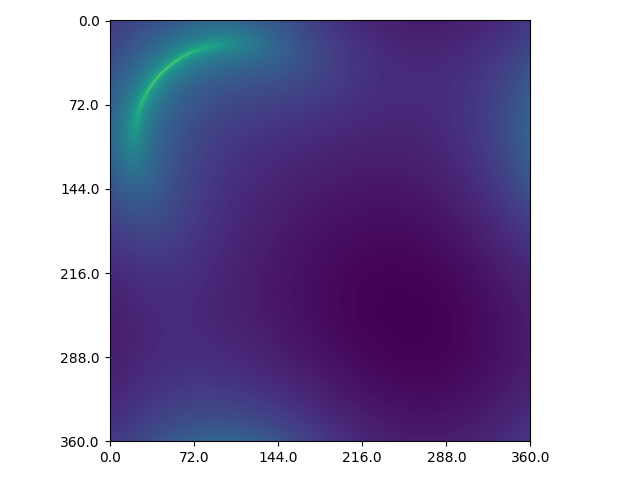

In [49]:
%matplotlib notebook
st_state.plot_energy(film_inst.l1.Ms, film_inst.l2.Ms,
        H_val, tet_val,
        Ku1_val, Ku2_val,
        film_inst,
        ang0_diap_grad = np.array([0., 2*180.]),
        ang1_diap_grad = np.array([0., 2*180.]),
        power = 0.1,
        sign = -1
    )

<IPython.core.display.Javascript object>


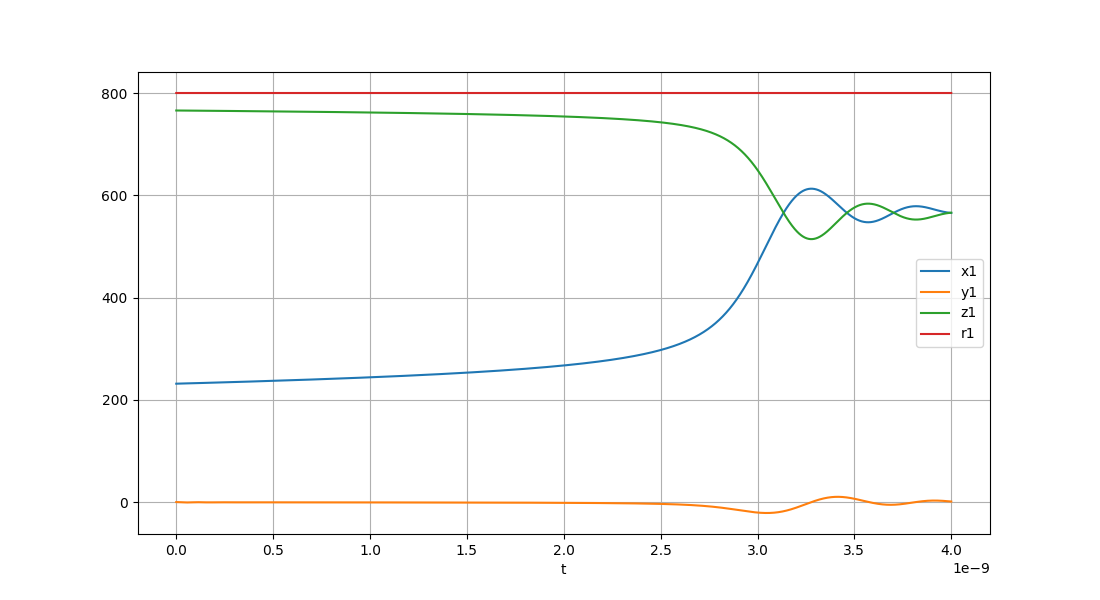

In [97]:
# %matplotlib inline
%matplotlib notebook
#%matplotlib qt

df.plot(x='t', y=['x1', 'y1', 'z1', 'r1'], figsize = (11, 6))
plt.grid(True)

<IPython.core.display.Javascript object>


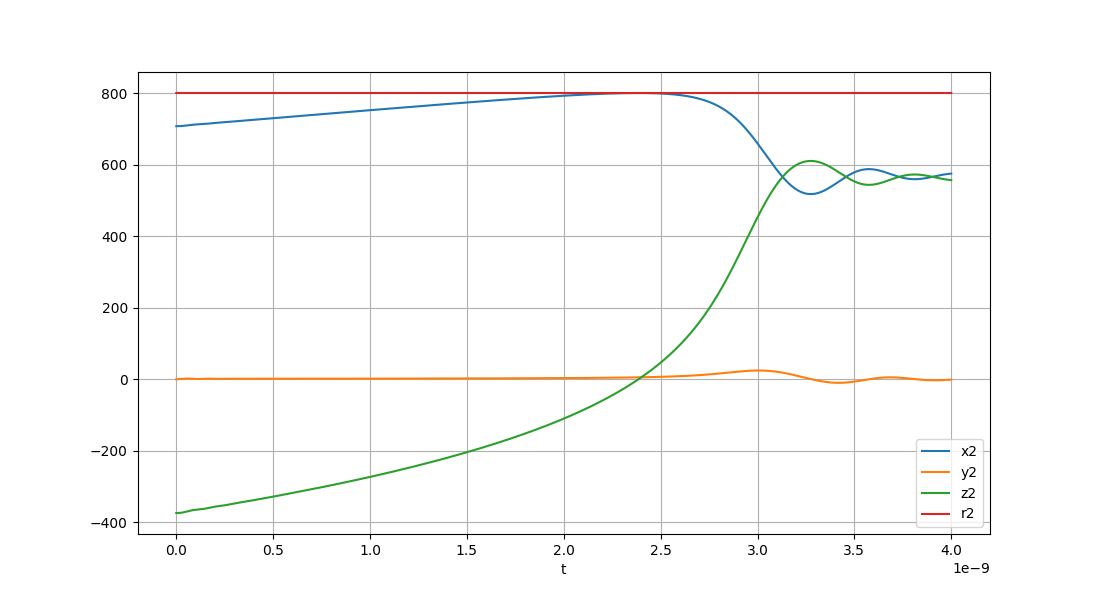

In [98]:
# %matplotlib inline
%matplotlib notebook
#%matplotlib qt

df.plot(x='t', y=['x2', 'y2', 'z2', 'r2'], figsize = (11, 6))
plt.grid(True)

<IPython.core.display.Javascript object>


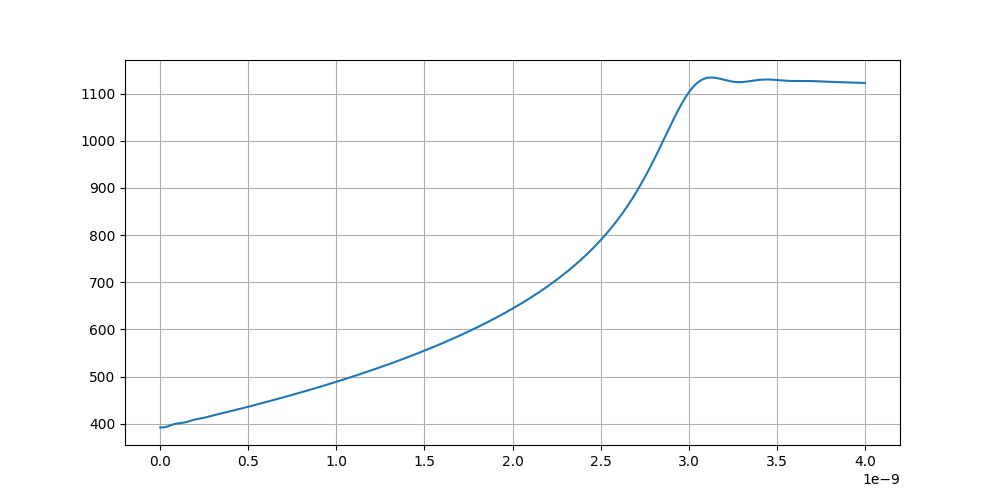

In [101]:
%matplotlib notebook
plt.subplots(figsize = (10, 5))
plt.plot(df.t, df.z1 + df.z2)
#plt.plot(df.t, df.y1 + df.y2)
#plt.plot(df.t, df.z1)
#plt.plot(df.t, df.z2)
plt.grid(True)

<IPython.core.display.Javascript object>


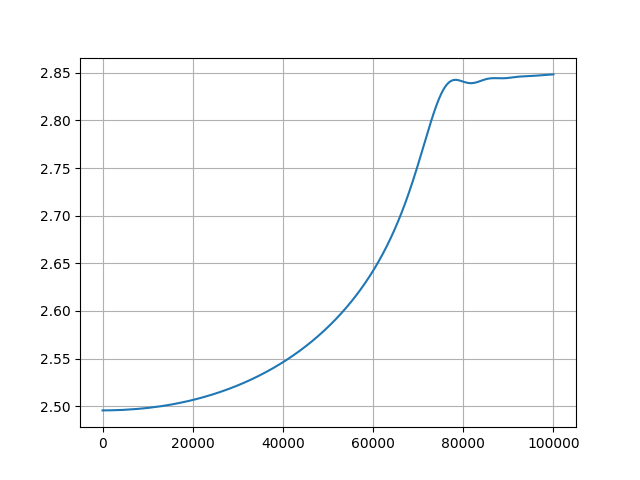

In [99]:
%matplotlib notebook
tmp = st_state2.Es_lamb(
    df.x1, df.y1, df.z1,
    df.x2, df.y2, df.z2,
    Hext[0], Hext[1], Hext[2],
    Ku1_val, Ku2_val,
    film_inst.J,
    film_inst.l1.t, film_inst.l2.t
)

tmp.plot()
plt.grid()


In [43]:
from scipy.optimize import curve_fit

def func3(x, fi0, f, tau1, tau2, tau3, A1, A2, A3, C):
    return A1*np.exp(-x/tau1)*np.cos(2*np.pi*f*x + fi0) + C + A2*np.exp(-(x-t0_M)/tau2) + A3*np.exp(-(x-Ku_t0)/tau3)

def func2(x, fi0, f, tau1, tau2, A1, A2, C):
    return A1*np.exp(-x/tau1)*np.cos(2*np.pi*f*x + fi0) + C + A2*np.exp(-x/tau2)

#par, ss = curve_fit(func2, df.t, df.z2, p0=[0, 18e9, 0.3e-9,0.3e-9, 200, 50, 600], maxfev=10000)
par, ss = curve_fit(func3, df.t[df.t>t0_M], df.z2[df.t>t0_M] + df.z1[df.t>t0_M], p0=[0, 14e9, tau_M,Ku_tau, 12e-12, 2., 1., 2., 0.], maxfev=10000)

print(par)
print("f={} GHz".format(par[1]*1e-9))

#plt.plot(df.t, func2(df.t, *par))
plt.plot(df.t[df.t>t0_M], func3(df.t[df.t>t0_M], *par))

[-1.47181615e+01  8.91864980e+09 -2.34856410e-07 -7.44135148e-10
  3.00816989e-08 -1.23837763e+00 -1.56828158e+01 -1.16011243e+03
  1.56354453e+03]
f=8.918649796523223 GHz


<IPython.core.display.Javascript object>


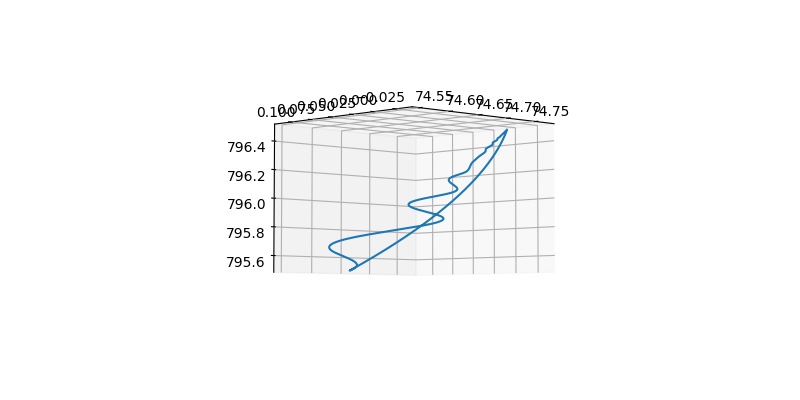

In [32]:
#%matplotlib inline
%matplotlib notebook
#%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])

1.2499875

'delta: 1.2499875'

<IPython.core.display.Javascript object>


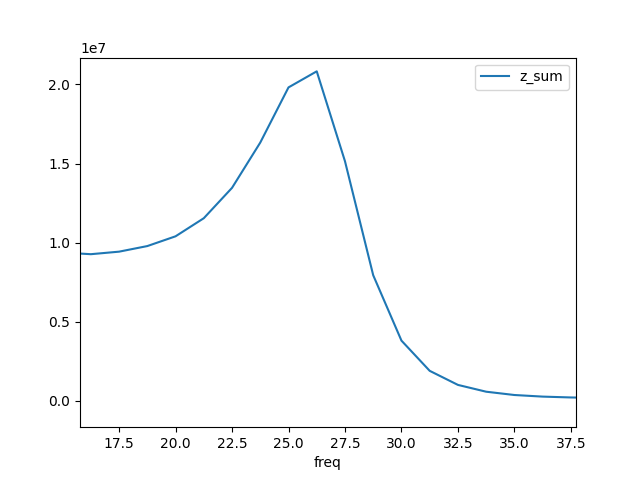

,freq,x1,y1,z1,x2,y2,z2,z_sum
0,1.249988,3.125148e+08,336832.481129,9.566375e+06,3.125317e+08,337041.568003,9.569999e+06,3.827275e+07
1,2.499975,1.282783e+08,574195.657707,5.847896e+06,1.282866e+08,574298.448292,5.849495e+06,2.339478e+07
2,3.749963,6.438626e+07,651490.029034,4.671591e+06,6.438667e+07,651489.767930,4.671005e+06,1.868519e+07
3,4.999950,3.728599e+07,675817.651972,3.993548e+06,3.728441e+07,675796.781262,3.993301e+06,1.597370e+07
4,6.249938,2.273246e+07,675134.919210,3.514290e+06,2.273256e+07,675136.858031,3.514647e+06,1.405787e+07
...,...,...,...,...,...,...,...,...
194,243.747563,1.434151e+03,382.207781,1.405893e+03,1.434329e+03,382.211001,1.405716e+03,5.623217e+03
195,244.997550,1.482272e+03,377.760027,1.362855e+03,1.482251e+03,377.758619,1.362850e+03,5.451410e+03
196,246.247538,1.516718e+03,372.597502,1.319951e+03,1.516536e+03,372.594321,1.320121e+03,5.280144e+03
197,247.497525,1.413445e+03,365.475404,1.310021e+03,1.413454e+03,365.476725,1.310026e+03,5.240093e+03


In [58]:
%matplotlib notebook
freq_df = pd.DataFrame(columns=['freq','x1','y1','z1','x2','y2','z2'])

freq_df['freq'] = np.fft.fftfreq(len(df.t), df.t[1]-df.t[0])[1:200] * 1e-9

column_names = ['x1','y1','z1','x2','y2','z2']
for name in column_names:
    freq_df[name] = np.abs(np.fft.fft(df[name]))[1:200]**2

freq_df["z_sum"] = np.abs(np.fft.fft(df.z1 + df.z2))[1:200]**2

display(freq_df['freq'][freq_df['z1'].argmax()])
display("delta: {}".format(freq_df.freq[1]-freq_df.freq[0]))
#freq_df.plot(x='freq', y=['x1','y1', 'z1', 'x2', 'y2', 'z2'])
freq_df.plot(x='freq', y=['z_sum'])
freq_df

# Legacy Code

In [6]:
%load_ext jupyter_spaces

In [91]:
%%space space1

S = CoordSys3D('S')

Mx, My, Mz = symbols("M_x M_y M_z")
M = S.i*Mx + S.j*My + S.k*Mz

Hx, Hy, Hz = symbols("H_x H_y H_z")
H = S.i*Hx + S.j*Hy + S.k*Hz

Ku = symbols("K_u")

sin_tet2 = (Mx**2 + My**2)/(Mx**2 + My**2 + Mz**2)
Ev = -H.dot(M) + 2*sym.pi*(M.dot(S.k)**2) + Ku*sin_tet2

varset = (
    Mx, My, Mz,
    Hx, Hy, Hz,
    Ku
)
Ev_lamb = lambdify(varset, Ev)



-H_x*M_x - H_y*M_y - H_z*M_z + K_u*(M_x**2 + M_y**2)/(M_x**2 + M_y**2 + M_z**2) + 2*pi*M_z**2

In [ ]:
%%space space2
